In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import necessary libraries and pacakages
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import statsmodels.api as sm
from scipy import stats
import yfinance as yf
import requests
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
# Load in the data
balance_sheets = pd.read_csv('/content/drive/MyDrive/Home-Depot-CSV-Files/CONSOLIDATED BALANCE SHEETS.csv')
statements_of_earnings = pd.read_csv('/content/drive/MyDrive/Home-Depot-CSV-Files/CONSOLIDATED STATEMENTS OF EARN.csv')
statements_of_cash = pd.read_csv('/content/drive/MyDrive/Home-Depot-CSV-Files/CONSOLIDATED STATEMENTS OF CASH.csv')

# Display the first few rows of each dataframe to understand the data
print("Balance Sheets:")
print(balance_sheets.head())
print("\nStatements of Earnings:")
print(statements_of_earnings.head())
print("\nStatements of Cash Flows:")
print(statements_of_cash.head())

Balance Sheets:
  CONSOLIDATED BALANCE SHEETS - USD ($) $ in Millions Jan. 28, 2024  \
0                                    Current assets:                  
1                          Cash and cash equivalents           3760   
2                                   Receivables, net           3328   
3                            Merchandise inventories          20976   
4                               Other current assets           1711   

  Jan. 29, 2023  
0                
1          2757  
2          3317  
3         24886  
4          1511  

Statements of Earnings:
  CONSOLIDATED STATEMENTS OF EARNINGS - USD ($) shares in Millions, $ in Millions  \
0                                                NaN                                
1                        Income Statement [Abstract]                                
2                                          Net sales                                
3                                      Cost of sales                                

In [4]:
# Data cleaning- Clean and convert columns to numeric types
def clean_and_convert_columns_to_numeric(df):
    # Replace non-breaking space with a regular space
    df = df.replace('\xa0', ' ', regex=True)
    # Convert all columns except the first one to numeric, forcing errors to NaN
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    # Forward fill and backward fill missing values
    df = df.fillna(method='ffill').fillna(method='bfill')
    return df

# Apply the cleaning and conversion function to the statements_of_earnings DataFrame
statements_of_earnings = clean_and_convert_columns_to_numeric(statements_of_earnings)

In [5]:
# Feature Engineering
net_sales_column = '12 Months Ended'

# Calculate lagged values and growth rates
statements_of_earnings['Net Sales Lag 1'] = statements_of_earnings[net_sales_column].shift(1)
statements_of_earnings['Net Sales Growth'] = statements_of_earnings[net_sales_column].pct_change()

# Drop rows with NaN values resulting from the shift and pct_change operations
statements_of_earnings.dropna(inplace=True)

# Display the first few rows to verify the changes
print(statements_of_earnings.head())

  CONSOLIDATED STATEMENTS OF EARNINGS - USD ($) shares in Millions, $ in Millions  \
1                        Income Statement [Abstract]                                
2                                          Net sales                                
3                                      Cost of sales                                
4                                       Gross profit                                
5                                Operating expenses:                                

   12 Months Ended  Unnamed: 2  Unnamed: 3  Net Sales Lag 1  Net Sales Growth  
1         152669.0    157403.0    151157.0         152669.0          0.000000  
2         152669.0    157403.0    151157.0         152669.0          0.000000  
3         101709.0    104625.0    100325.0         152669.0         -0.333794  
4          50960.0     52778.0     50832.0         101709.0         -0.498963  
5          50960.0     52778.0     50832.0          50960.0          0.000000  


In [6]:
# Create more lagged variables and growth rates
statements_of_earnings['Net Sales Lag 2'] = statements_of_earnings[net_sales_column].shift(2)
statements_of_earnings['Net Sales Growth 2'] = statements_of_earnings[net_sales_column].pct_change(2)

# Drop rows with NaN values resulting from the new shift and pct_change operations
statements_of_earnings.dropna(inplace=True)

In [7]:
# Feature scaling- Standardizing the features
scaler= StandardScaler()
scaled_features= scaler.fit_transform(statements_of_earnings[['Net Sales Lag 1', 'Net Sales Growth', 'Net Sales Lag 2', 'Net Sales Growth 2']])
scaled_df= pd.DataFrame(scaled_features, columns= ['Net Sales Lag 1', 'Net Sales Growth', 'Net Sales Lag 2', 'Net Sales Growth 2'])

# Concatenate the scaled features back to their original dataframe
statements_of_earnings.reset_index(drop= True, inplace= True)
final_df= pd.concat([statements_of_earnings, scaled_df], axis= 1)

# Display the first view rows to verify changes
final_df.head()

,"CONSOLIDATED STATEMENTS OF EARNINGS - USD ($) shares in Millions, $ in Millions",12 Months Ended,Unnamed: 2,Unnamed: 3,Net Sales Lag 1,Net Sales Growth,Net Sales Lag 2,Net Sales Growth 2,Net Sales Lag 1,Net Sales Growth,Net Sales Lag 2,Net Sales Growth 2
0,Cost of sales,101709.0,104625.0,100325.0,152669.0,-0.333794,152669.0,-0.333794,3.165647,-0.266197,2.422283,-0.089060
1,Gross profit,50960.0,52778.0,50832.0,101709.0,-0.498963,152669.0,-0.666206,1.871873,-0.276839,2.422283,-0.175881
2,Operating expenses:,50960.0,52778.0,50832.0,50960.0,0.000000,101709.0,-0.498963,0.583456,-0.244688,1.360571,-0.132200
3,"Selling, general and administrative",26598.0,26284.0,25406.0,50960.0,-0.478061,50960.0,-0.478061,0.583456,-0.275493,0.303255,-0.126740
4,Depreciation and amortization,2673.0,2455.0,2386.0,26598.0,-0.899504,50960.0,-0.947547,-0.035047,-0.302649,0.303255,-0.249364


In [8]:
# Display the first few rows of the statements_of_earnings DataFrame (confirming target feature)
print(statements_of_earnings.head())

  CONSOLIDATED STATEMENTS OF EARNINGS - USD ($) shares in Millions, $ in Millions  \
0                                      Cost of sales                                
1                                       Gross profit                                
2                                Operating expenses:                                
3                Selling, general and administrative                                
4                      Depreciation and amortization                                

   12 Months Ended  Unnamed: 2  Unnamed: 3  Net Sales Lag 1  Net Sales Growth  \
0         101709.0    104625.0    100325.0         152669.0         -0.333794   
1          50960.0     52778.0     50832.0         101709.0         -0.498963   
2          50960.0     52778.0     50832.0          50960.0          0.000000   
3          26598.0     26284.0     25406.0          50960.0         -0.478061   
4           2673.0      2455.0      2386.0          26598.0         -0.899504   

  

In [9]:
# Display the unique values in the '12 Months Ended' column (confirming target feature)
print(statements_of_earnings['12 Months Ended'].unique())

[ 1.01709e+05  5.09600e+04  2.65980e+04  2.67300e+03  2.92710e+04
  2.16890e+04 -1.78000e+02  1.94300e+03  1.76500e+03  1.99240e+04
  4.78100e+03  1.51430e+04  9.99000e+02  1.51600e+01  1.00200e+03
  1.51100e+01]


In [10]:
# Define the features and the target variable
features = ['Net Sales Lag 1', 'Net Sales Growth', 'Net Sales Lag 2', 'Net Sales Growth 2']
target = '12 Months Ended'

X = statements_of_earnings[features]
y = statements_of_earnings[target]

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (14, 4)
X_test shape: (4, 4)
y_train shape: (14,)
y_test shape: (4,)


In [12]:
# Linear Regression Model
lr_model= LinearRegression()

# Train the model on the training daata
lr_model.fit(X_train, y_train)

LinearRegression()

In [13]:
# Make predictions on the test data set
y_pred_lr= lr_model.predict(X_test)

In [14]:
# Evaluate the model performance
mae_lr= mean_absolute_error(y_test, y_pred_lr)
rmse_lr= mean_squared_error(y_test, y_pred_lr, squared= False)

print('Lineaer Regression MAE: ', mae_lr)
print('Linear Regression RMSE: ', rmse_lr)

Lineaer Regression MAE:  17098.36570502546
Linear Regression RMSE:  17306.38482199493


In [15]:
# Define the parameter grid for the RandomForest Model
param_grid_rf = {
    'n_estimators': [100, 200, 500, 1000, 1500, 2000],  # Number of trees in the forest
    'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4, 6, 8],  # Minimum number of samples required to be at a leaf node
    'bootstrap': [True, False]  # Method of selecting samples for training each tree
}

# RandomForest Model
rf_model= RandomForestRegressor(random_state= 42)

# RandomizedSearchCV with cross validation
rf_random_search= RandomizedSearchCV(estimator= rf_model, param_distributions= param_grid_rf, n_iter= 200, cv= 3, verbose= 2, random_state= 42, n_jobs= -1)

In [16]:
# Fit the RandomForest model
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40, 50,
                                                      60, 70, 80, 90, 100],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 15, 20],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         1500, 2000]},
                   random_state=42, verbose=2)

In [17]:
# Get the best parameters
best_rf_model= rf_random_search.best_estimator_
print('Best parameters for the RandomForest: ', best_rf_model)

Best parameters for the RandomForest:  RandomForestRegressor(max_features='log2', n_estimators=1500, random_state=42)


In [18]:
# Make predictions on the test data
y_pred_rf= best_rf_model.predict(X_test)

In [19]:
# Evaluate model performance
mae_rf= mean_absolute_error(y_test, y_pred_rf)
rmse_rf= mean_squared_error(y_test, y_pred_rf, squared= False)

print('RandomForest MAE: ', mae_rf)
print('RandomForest RMSE: ', rmse_rf)

RandomForest MAE:  25735.32792833334
RandomForest RMSE:  35224.05761173954


In [20]:
# Define the expanded parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200, 500, 1000, 1500, 2000],  # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3, 4, 5],  # Minimum sum of instance weight (hessian) needed in a child
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],  # Minimum loss reduction required to make a further partition on a leaf node
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of the training instances
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],  # Subsample ratio of columns when constructing each tree
    'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5, 1],  # L1 regularization term on weights
    'reg_lambda': [0, 0.01, 0.05, 0.1, 0.5, 1]  # L2 regularization term on weights
}

# XGBoost Model
xgb_model = XGBRegressor(random_state=42)

# RandomizedSearchCV with cross-validation
xgb_random_search = RandomizedSearchCV(estimator= xgb_model, param_distributions= param_grid_xgb, n_iter= 2000, cv= 3, verbose= 2, random_state= 42, n_jobs= -1)

In [21]:
# Fit the XGBoost Model
xgb_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8, 0.9,
                                                             1.0],
                                        'gamma': [0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
                                        'min_child_weight': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         1500, 2000],
                                        'reg_alpha': [0, 0.01, 0.05, 0.1, 0.5,
                                                      1],
                                        'reg_lambda': [0, 0.01, 0.05, 0.1, 0.5,
                                                       1],
                                        'subsample': [0.6, 0.7, 0.8, 0.9, 1.0]},
                   random_state=42, verbose=2)

In [22]:
# Get the best model
best_xgb_model= xgb_random_search.best_estimator_

In [23]:
# Make predictions on the test data
y_pred_xgb= best_xgb_model.predict(X_test)

In [24]:
# Evaluate Model Performance
mae_xgb= mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb= mean_squared_error(y_test, y_pred_xgb, squared= False)

print('XGBoost MAE: ', mae_xgb)
print('XGBoost RMSE: ', rmse_xgb)

XGBoost MAE:  29184.095092773438
XGBoost RMSE:  39088.65009723139


In [25]:
# Reshape the data for the Long Short-Term Memory Recurrent Neural Network
X_train_lstm = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train_lstm shape:", X_train_lstm.shape)
print("X_test_lstm shape:", X_test_lstm.shape)

X_train_lstm shape: (14, 4, 1)
X_test_lstm shape: (4, 4, 1)


In [26]:
# LSTM Model- First LSTM layer with Dropout regularization
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [27]:
# Fit the LSTM Model
history= model.fit(X_train_lstm, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 403258368.0000 - val_loss: 158174624.0000
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 403255776.0000 - val_loss: 158173248.0000
Epoch 3/100
1/1 [==============================] - 0s 61ms/step - loss: 403253664.0000 - val_loss: 158171968.0000
Epoch 4/100
1/1 [==============================] - 0s 76ms/step - loss: 403254144.0000 - val_loss: 158170640.0000
Epoch 5/100
1/1 [==============================] - 0s 85ms/step - loss: 403251584.0000 - val_loss: 158169328.0000
Epoch 6/100
1/1 [==============================] - 0s 49ms/step - loss: 403249856.0000 - val_loss: 158167872.0000
Epoch 7/100
1/1 [==============================] - 0s 52ms/step - loss: 403248224.0000 - val_loss: 158166320.0000
Epoch 8/100
1/1 [==============================] - 0s 50ms/step - loss: 403244064.0000 - val_loss: 158164688.0000
Epoch 9/100
1/1 [==============================] - 0s 46ms/step - loss: 403242496.0000 - v

In [28]:
# Make predictions on the test data
y_pred_lstm = model.predict(X_test_lstm)

1/1 [==============================] - 1s 761ms/step


In [29]:
# Evaluate model performance
# Evaluate the model performance
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
rmse_lstm = mean_squared_error(y_test, y_pred_lstm, squared=False)

print("LSTM MAE:", mae_lstm)
print("LSTM RMSE:", rmse_lstm)

LSTM MAE: 45502.08853149414
LSTM RMSE: 58691.02735941822


**Best Model**

The Linear Regression model remains the best-performing model based on the MAE and RMSE metrics. This suggests that for predicting Home Depot's quarterly revenue, the simpler Linear Regression model is more suitable.

Now, I'll proceed with retraining the linear regression model to ensure it is finalized with the best possible performance.

In [30]:
# Retrain Linear Regression Model
lin_reg_model= LinearRegression()

# Fit the model
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [31]:
# Make predictions on the test data
y_pred_lr = lin_reg_model.predict(X_test)

In [32]:
# Evaluate the model performance
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print('Final Linear Regression MAE: ', mae_lr)
print('Final Linear Regression RMSE: ', rmse_lr)

Final Linear Regression MAE:  17098.36570502546
Final Linear Regression RMSE:  17306.38482199493


**Linear Regression Model**

Now, I will analyze the coefficients of the Linear Regression model to understand the impact of the different features.

In [33]:
# Get the coefficients of the model
coefficients = lin_reg_model.coef_
intercept = lin_reg_model.intercept_

# Print the coefficients and intercept
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Create a DataFrame for better visualization
coef_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': coefficients})
display(coef_df)

Intercept: 1748.3591704624632
Coefficients: [2.74692186e-01 2.56865630e+01 2.63041745e-01 1.00808109e+03]


,Feature,Coefficient
0,Net Sales Lag 1,0.274692
1,Net Sales Growth,25.686563
2,Net Sales Lag 2,0.263042
3,Net Sales Growth 2,1008.081087


In [34]:
# Save the Linear Regression model with joblib
joblib.dump(lin_reg_model, 'linear_regression_model.pkl')

['linear_regression_model.pkl']

In [35]:
# Load the Linear Regression Model
loaded_model= joblib.load('linear_regression_model.pkl')
print('Linear Regression Model has been loaded successfully')

Linear Regression Model has been loaded successfully


In [36]:
# Make predictions on the test data using the loaded model
y_pred_loaded= loaded_model.predict(X_test)

In [38]:
# Diplay the first few predictions along with the actual values
results_loaded= pd.DataFrame({'Actual': y_test.values.flatten(), 'Predicted': y_pred_loaded})
results_loaded.head()

,Actual,Predicted
0,101709.0,83498.595140
1,50960.0,69160.940542
2,-178.0,12369.018685
3,29271.0,9835.901266


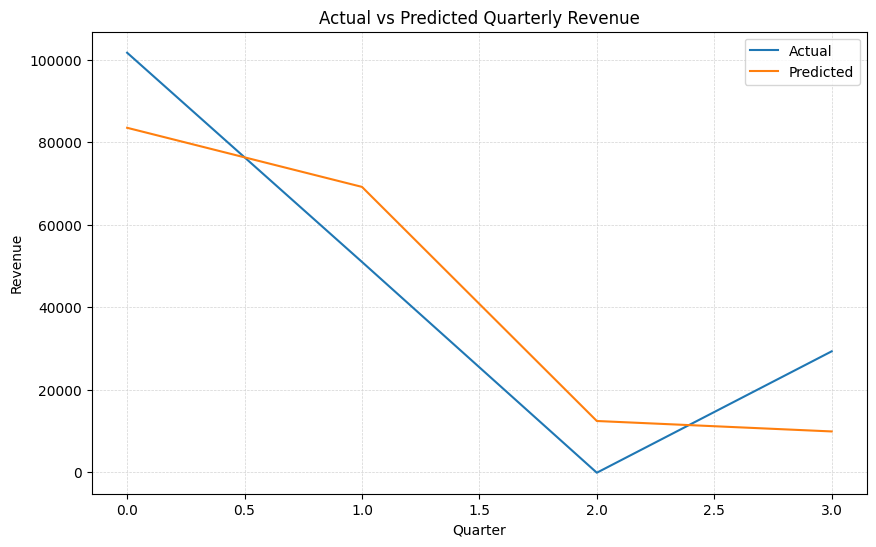

In [41]:
# Plotting the Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values.flatten(), label='Actual')
plt.plot(y_pred_loaded, label='Predicted')
plt.title('Actual vs Predicted Quarterly Revenue')
plt.xlabel('Quarter')
plt.ylabel('Revenue')
plt.grid(True, linestyle= '--', linewidth= 0.5, color= 'lightgray')
plt.legend()
plt.show()

In [42]:
# Evaluate the model performance
mae_loaded = mean_absolute_error(y_test, y_pred_loaded)
rmse_loaded = mean_squared_error(y_test, y_pred_loaded, squared=False)
print(f"MAE of loaded model: {mae_loaded}")
print(f"RMSE of loaded model: {rmse_loaded}")

MAE of loaded model: 17098.36570502546
RMSE of loaded model: 17306.38482199493
